### Heart Rate Measurement using the **Green Channel**


In [21]:
# ------Import standard libraries------
import math
import cv2
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
#from scipy.fft import fft
from numpy.fft import fft

# import the cv2_imshow function  from patches to use in Google Collab
# import functions from the scipy.signal module for signal processing
from scipy.signal import butter, filtfilt, find_peaks
import scipy.signal as signal
#import and mount the drive module to access files and directories from Google Drive
import pandas as pd


In [22]:
import cv2
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
# Carga el clasificador Haarcascade preentrenado para detección de caras
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Carga el video desde tu computadora a Google Colab
video_filename = "Juan60.mp4"
# Abre el video
cap = cv2.VideoCapture(video_filename)
fps = cap.get(cv2.CAP_PROP_FPS)
fs = round(fps)
print(fs)

60


In [23]:
saturation_values = []  # Lista para almacenar los valores de saturación

# Leer el video fotograma a fotograma
while True:
    ret, frame = cap.read()
    if not ret:
        break  # Salir del bucle si no quedan más fotogramas

    # Convertir a escala de grises para la detección de rostros
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detectar rostros
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) > 0:
        # Tomar el primer rostro detectado
        x, y, w, h = faces[0]

        # Definir una ROI para el rostro entero
        roi = frame[y:y+h, x:x+w]

        # Convertir la ROI a HSV
        hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_roi)

        # Calcular la intensidad promedio del canal de saturación en la ROI
        saturation_values.append(np.mean(h))

# Convertir la lista de valores de saturación a un array de numpy
saturation_array = np.array(saturation_values)


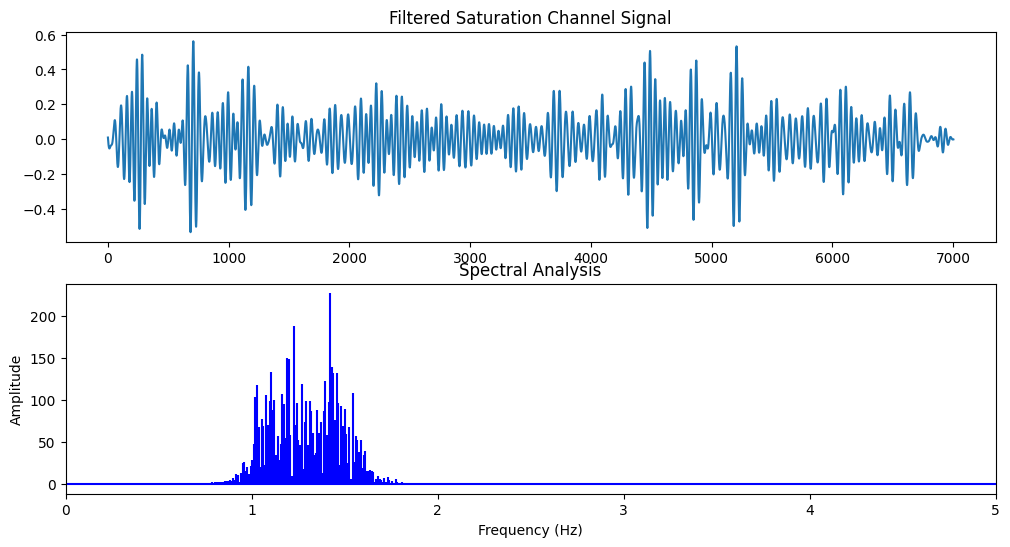

Estimated Heart Rate: 85.3 beats per minute


In [24]:

# Aplicar un filtro pasa banda para obtener la señal del pulso
lowcut = 1.0
highcut = 1.6

# Función para crear un filtro pasa banda Butterworth
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Función para aplicar el filtro
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filtrar la señal
filtered_saturation = butter_bandpass_filter(saturation_array, lowcut, highcut, fs, order=5)

# Realizar FFT en la señal filtrada
saturation_fft = fft(filtered_saturation)

# Calcular las frecuencias correspondientes
freqs = np.fft.fftfreq(len(filtered_saturation), 1/fs)

# Encuentra la frecuencia con la magnitud más alta en el rango de la frecuencia cardíaca
idx = np.argmax(np.abs(saturation_fft))
pulse_freq = freqs[idx]
heart_rate = pulse_freq * 60  # Convertir a latidos por minuto

# Mostrar los resultados
plt.figure(figsize=(12, 6))

# Mostrar la señal temporal filtrada
plt.subplot(2, 1, 1)
plt.plot(filtered_saturation)
plt.title('Filtered Saturation Channel Signal')

# Mostrar el espectro de la señal
plt.subplot(2, 1, 2)
plt.stem(freqs, np.abs(saturation_fft), 'b', markerfmt=" ", basefmt="-b")
plt.title('Spectral Analysis')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)  # Limitar el eje x al rango de interés para la frecuencia cardíaca
plt.show()

print(f'Estimated Heart Rate: {heart_rate:.1f} beats per minute')

# Libera el capturador de video
cap.release()

In [25]:
#------Compare to the heart rate calculated from pulse oximeter measurements------

# import the pulse oximeter .csv file
data_video= pd.read_csv('juan_60_20230429154535.csv')

# extract the data from the PULSE column
pulse_signal = data_video['PULSE']

# eliminate the first 10 seconds and and take the next 60 values of the signal
pulse_signal = pulse_signal[47:107]

# print the size of the signal (must be 60 for 60 seconds)
print("Signal size:", pulse_signal.size)

# calculate and print the average value of the Heart Rate
heart_rate_csv = np.mean(pulse_signal)
print("\nHeart rate: {:.2f} bpm".format(heart_rate_csv))

# calculate and print the error
error=abs(heart_rate-heart_rate_csv)
print("\nError: {:.2f} bpm".format(error))

Signal size: 60

Heart rate: 85.35 bpm

Error: 0.00 bpm
